In [ ]:
# Installazione dei pacchetti richiesti
!pip install rdkit-pypi
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 61.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.5 MB/s eta 0:00:00


In [ ]:
# Librerie Standard
import os
from copy import deepcopy
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from IPython.display import display, HTML

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

In [ ]:
# Caricamento dei dati dal file CSV
data = pd.read_csv('/content/D3_226k_docking_results.csv', sep=';')
docking_scores = data['Docking_scores'].str.replace(',', '.').astype(float).values
smiles_list = data['SMILES'].values

# Rimuovi le righe con valori mancanti in 'SMILES' o 'Docking_scores'
data = data.dropna(subset=['SMILES', 'Docking_scores'])

In [ ]:
# Converte un atomo in una lista di caratteristiche (numero atomico, grado, carica formale, tipo di ibridazione, aromaticità).
def atom_features(atom):
    return np.array([
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        int(atom.GetHybridization()),
        int(atom.GetIsAromatic())
    ], dtype=np.float32)

# Converte una stringa SMILES in un grafo molecolare
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None

    atom_features_list = [atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features_list, dtype=torch.float)
    edge_index = []
    edge_attr = [] # Lista per gli attributi dei legami
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # Aggiunta indici degli atomi collegati
        edge_index.append([i, j])
        edge_index.append([j, i])

        # Aggiunta attributi del legame
        bond_type = bond.GetBondTypeAsDouble()  # Tipo di legame (1.0: singolo, 2.0: doppio, ecc.)
        is_aromatic = bond.GetIsAromatic()      # Aromaticità del legame (True/False)

        # Codifica come attributo numerico
        edge_attr.append([bond_type, int(is_aromatic)])
        edge_attr.append([bond_type, int(is_aromatic)])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    data_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data_graph, mol

In [ ]:
# Imposta uno stile estetico per le figure
sns.set(style="whitegrid")

def visualize_molecule_graph(mol, data_graph):
    # Crea il grafo con NetworkX per la visualizzazione
    G = nx.Graph() # Inizializza un grafo vuoto

    # Per ogni atomo, aggiunge un nodo al grafo con un'etichetta che rappresenta il simbolo chimico
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        G.add_node(idx, label=atom.GetSymbol())

    # Per ogni legame, aggiunge un arco tra i due atomi coinvolti
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        G.add_edge(i, j)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    for ax in axs:
        rect = plt.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes,
            color='black', fill=False, linewidth=3
        )
        ax.add_patch(rect)

    # Imposta lo sfondo del subplot di NetworkX
    axs[0].set_facecolor('lightgrey')

    pos = nx.spring_layout(G, seed=42, center=(0, 0))

    axs[0].set_xlim([-1.2, 1.2])  # Regola i limiti in x
    axs[0].set_ylim([-1.2, 1.2])  # Regola i limiti in y
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(
        G, pos, with_labels=True, labels=labels, node_size=400, font_size=10,
        font_color="white", ax=axs[0], node_color='skyblue', edge_color='gray',
        linewidths=2, font_weight='bold'
    )

    # Riapplica lo sfondo dopo il disegno
    axs[0].set_facecolor('lightgrey')
    axs[0].set_title('Grafo Molecolare', fontsize=12)

    img = Draw.MolToImage(mol, size=(250, 250))
    axs[1].imshow(img, aspect='equal')
    axs[1].axis('off')
    axs[1].set_title('Molecola RDKit', fontsize=12)

    plt.subplots_adjust(wspace=0.5) # Spazio orizzontale tra i subplots
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

<ipython-input-4-7d8429776fe0>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.tensor(atom_features_list, dtype=torch.float)


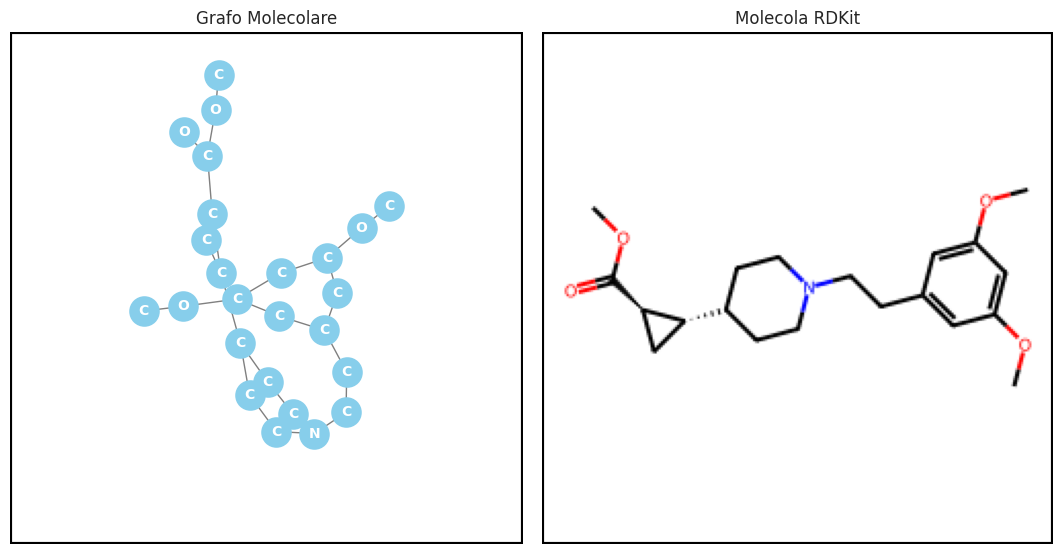

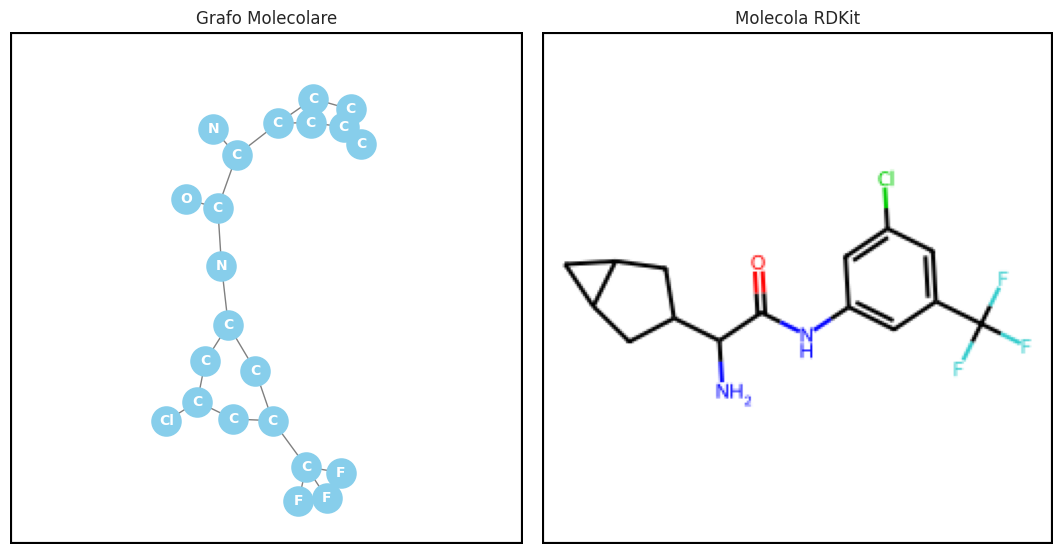

In [ ]:
# Applica le funzioni ai primi 2 SMILES e visualizza
for smiles in data['SMILES'].head(2):
    data_graph, mol = smiles_to_graph(smiles)
    if data_graph is not None and mol is not None:
        visualize_molecule_graph(mol, data_graph)


In [ ]:
graphs = []

for smiles, docking_score in zip(smiles_list, docking_scores):
    graph_data, _ = smiles_to_graph(smiles)
    if graph_data is not None:
        # Aggiungi il docking score come target
        graph_data.y = torch.tensor([docking_score], dtype=torch.float)
        graphs.append(graph_data)

In [ ]:
# Funzione per eliminare i duplicati mantenendo solo la prima occorrenza
def remove_duplicates(graphs):
    unique_graphs = []
    seen_graphs = set()
    duplicates_count = 0

    for graph in graphs:
        # Converti i tensori in una tupla immutabile per confronti univoci
        graph_tuple = (tuple(graph.x.numpy().flatten()), tuple(graph.edge_index.numpy().flatten()))
        if graph_tuple not in seen_graphs:
            unique_graphs.append(graph)
            seen_graphs.add(graph_tuple)
        else:
            duplicates_count += 1

    return unique_graphs, duplicates_count

initial_count = len(graphs)
graphs, duplicates_count = remove_duplicates(graphs)
final_count = len(graphs)

# Stampa delle informazioni
print(f"Numero iniziale di grafi: {initial_count}")
print(f"Numero di duplicati trovati: {duplicates_count}")
print(f"Numero finale di grafi (senza duplicati): {final_count}")

Numero iniziale di grafi: 226650
Numero di duplicati trovati: 24589
Numero finale di grafi (senza duplicati): 202061


In [ ]:
# Shuffle dell'intera lista
graphs = shuffle(graphs, random_state=42)

# Suddivisione in training (80%) e temp (20%)
train_graphs, temp_graphs = train_test_split(graphs, test_size=0.2, random_state=42)

# Suddivisione di temp in validation (10%) e test (10%)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.33, random_state=42)

In [ ]:
scaler = StandardScaler()

# Estrai i docking scores dal set di training
train_docking_scores = np.array([graph.y.item() for graph in train_graphs]).reshape(-1, 1)
train_docking_scores_scaled = scaler.fit_transform(train_docking_scores).flatten()
for graph, y in zip(train_graphs, train_docking_scores_scaled):
#for graph, y in zip(train_graphs, train_docking_scores):
    graph.y = torch.tensor([y], dtype=torch.float)

# Validazione
val_docking_scores = np.array([graph.y.item() for graph in val_graphs]).reshape(-1, 1)
val_docking_scores_scaled = scaler.transform(val_docking_scores).flatten()
for graph, y in zip(val_graphs, val_docking_scores_scaled):
#for graph, y in zip(val_graphs, val_docking_scores):
    graph.y = torch.tensor([y], dtype=torch.float)

# Test
test_docking_scores = np.array([graph.y.item() for graph in test_graphs]).reshape(-1, 1)
test_docking_scores_scaled = scaler.transform(test_docking_scores).flatten()
for graph, y in zip(test_graphs, test_docking_scores_scaled):
#for graph, y in zip(test_graphs, test_docking_scores):
    graph.y = torch.tensor([y], dtype=torch.float)

In [ ]:
# Creazione dei DataLoader
batch_size = 64
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

In [ ]:
# Definizione della rete GNN
class GNNRegressor(nn.Module):
    def __init__(self, num_node_features, edge_dim, hidden_channels, dropout):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.edge_mlp = nn.Linear(edge_dim, hidden_channels)  # Layer per elaborare gli edge attributes
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin_bn = nn.BatchNorm1d(hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Elaborazione degli edge attributes
        edge_features = F.relu(self.edge_mlp(edge_attr))

        # Prima convoluzione
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x))
        x = self.dropout(x)

        # Seconda convoluzione
        x = self.conv2(x, edge_index)
        x = F.relu(self.bn2(x))
        x = self.dropout(x)

        # Pooling globale
        x = global_mean_pool(x, batch)

        # Layer finale
        x = self.lin1(x)
        x = F.relu(self.lin_bn(x))
        x = self.dropout(x)
        x = self.lin2(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilizzando il dispositivo: {device}")

Utilizzando il dispositivo: cuda


In [ ]:
num_node_features = 5
hidden_channels = 256
dropout = 0.3
edge_dim = 2  # Numero di caratteristiche per ogni legame
model = GNNRegressor(num_node_features=num_node_features, edge_dim=edge_dim, hidden_channels=hidden_channels, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.MSELoss()

In [ ]:
def train(model, optimizer, data_loader, criterion):
    model.train()
    total_loss = 0.0
    for batch in data_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    average_loss = total_loss / len(data_loader.dataset)
    return average_loss

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out.view(-1), batch.y.view(-1))
            total_loss += loss.item() * batch.num_graphs
    average_loss = total_loss / len(data_loader.dataset)
    return average_loss

def evaluate_metrics(model, data_loader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.view(-1).cpu().numpy())
            targets.append(batch.y.view(-1).cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    mse = ((preds - targets) ** 2).mean()
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)
    return mse, mae, r2

In [ ]:
# Funzione per stampare i risultati a ogni epoca
def display_epoch_results(epoch, num_epochs, train_loss,
                          val_loss, val_mse, val_mae, val_r2,
                          test_loss, test_mse, test_mae, test_r2):
    headers = ["Metric", "Training", "Validation", "Test"]
    rows = [
        ["Loss", f"{train_loss:.4f}", f"{val_loss:.4f}", f"{test_loss:.4f}"],
        ["MSE", "-", f"{val_mse:.4f}", f"{test_mse:.4f}"],
        ["MAE", "-", f"{val_mae:.4f}", f"{test_mae:.4f}"],
        ["R²", "-", f"{val_r2:.4f}", f"{test_r2:.4f}"],
    ]

    print("\n" + "=" * 60)
    print(f"  Epoch [{epoch + 1}/{num_epochs}] - Training and Evaluation Results")
    print("=" * 60)
    print(tabulate(rows, headers=headers, tablefmt="grid"))
    print("=" * 60)

def display_best_model_performance(val_loss, val_mse, val_mae, val_r2,
                                   test_loss, test_mse, test_mae, test_r2):
    headers = ["Metric", "Validation", "Test"]
    rows = [
        ["Loss", f"{val_loss:.4f}", f"{test_loss:.4f}"],
        ["MSE", f"{val_mse:.4f}", f"{test_mse:.4f}"],
        ["MAE", f"{val_mae:.4f}", f"{test_mae:.4f}"],
        ["R²", f"{val_r2:.4f}", f"{test_r2:.4f}"]
    ]

    header = f"{'#' * 20} Best Model Performance {'#' * 20}"
    divider = "-" * 80
    print(header)
    print(divider)
    print(tabulate(rows, headers=headers, tablefmt="grid"))
    print(divider)

In [ ]:
# Ciclo di addestramento con early stopping
num_epochs = 200
best_loss = np.inf
patience = 10
counter = 0
best_model_state = None

# Liste per salvare i valori di Loss e metriche durante le epoche
train_losses = []
val_losses = []
val_mses = []
val_maes = []
val_r2s = []
test_losses = []
test_mses = []
test_maes = []
test_r2s = []

# Percorso per salvare il modello
model_path = 'best_model.pth'

# Rimozione del file del modello se esiste già
if os.path.exists(model_path):
    os.remove(model_path)

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, train_loader, criterion)

    val_loss = evaluate(model, val_loader, criterion)
    val_mse, val_mae, val_r2 = evaluate_metrics(model, val_loader)

    test_loss = evaluate(model, test_loader, criterion)
    test_mse, test_mae, test_r2 = evaluate_metrics(model, test_loader)

    display_epoch_results(epoch, num_epochs, train_loss,
                          val_loss, val_mse, val_mae, val_r2,
                          test_loss, test_mse, test_mae, test_r2)

    # Salvataggio dei valori di Loss e metriche
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mses.append(val_mse)
    val_maes.append(val_mae)
    val_r2s.append(val_r2)
    test_losses.append(test_loss)
    test_mses.append(test_mse)
    test_maes.append(test_mae)
    test_r2s.append(test_r2)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

# Caricamento dello stato migliore del modello
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    torch.save(best_model_state, model_path)
    print("Best model loaded and saved.")

# Valutazione finale del modello migliore
val_loss = evaluate(model, val_loader, criterion)
val_mse, val_mae, val_r2 = evaluate_metrics(model, val_loader)
test_loss = evaluate(model, test_loader, criterion)
test_mse, test_mae, test_r2 = evaluate_metrics(model, test_loader)

display_best_model_performance(val_loss, val_mse, val_mae, val_r2,
                               test_loss, test_mse, test_mae, test_r2)


  Epoch [1/200] - Training and Evaluation Results
+----------+------------+--------------+--------+
| Metric   | Training   |   Validation |   Test |
+==========+============+==============+========+
| Loss     | 0.9337     |       0.8663 | 0.8827 |
+----------+------------+--------------+--------+
| MSE      | -          |       0.8663 | 0.8827 |
+----------+------------+--------------+--------+
| MAE      | -          |       0.7114 | 0.7188 |
+----------+------------+--------------+--------+
| R²       | -          |       0.1406 | 0.1379 |
+----------+------------+--------------+--------+

  Epoch [2/200] - Training and Evaluation Results
+----------+------------+--------------+--------+
| Metric   | Training   |   Validation |   Test |
+==========+============+==============+========+
| Loss     | 0.8614     |       0.8347 | 0.853  |
+----------+------------+--------------+--------+
| MSE      | -          |       0.8347 | 0.853  |
+----------+------------+--------------+--------

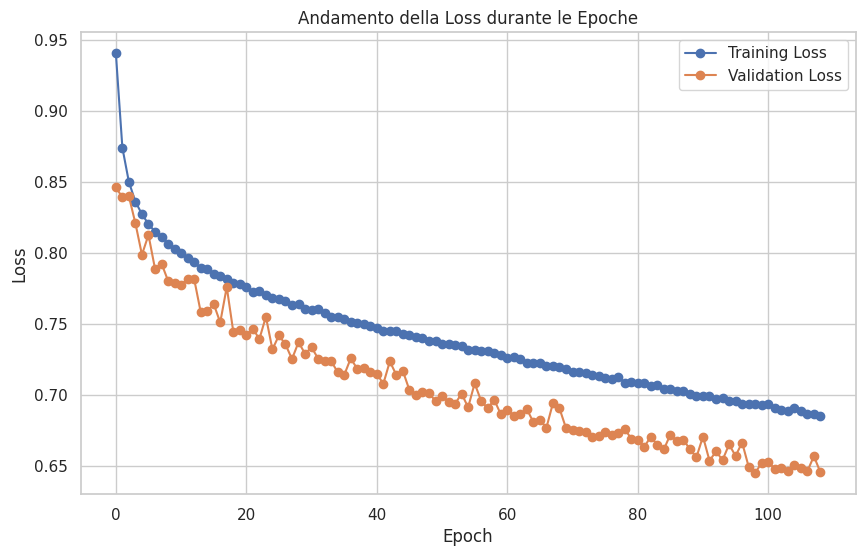

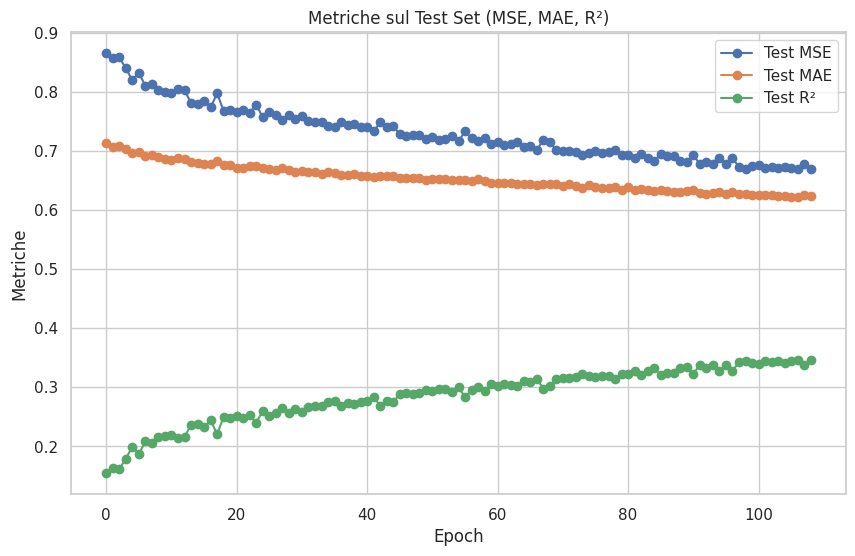

In [ ]:
# Plot dell'andamento della Loss durante le epoche
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Andamento della Loss durante le Epoche')
plt.legend()
plt.grid(True)
plt.show()

# Inserisci uno spazio HTML
display(HTML("<br><br><br>"))

# Plot delle metriche di test (MSE, MAE, R²)
plt.figure(figsize=(10, 6))
plt.plot(test_mses, label='Test MSE', marker='o')
plt.plot(test_maes, label='Test MAE', marker='o')
plt.plot(test_r2s, label='Test R²', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Metriche')
plt.title('Metriche sul Test Set (MSE, MAE, R²)')
plt.legend()
plt.grid(True)
plt.show()